In [1]:
import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
#Functions
def data_retrieval(sourcefile, metadata, pt_id):

	'''
	This function reads data for a single patient from a master spreadsheet with amplicon data for all plates/patients.
	Input is the sourcefile with the readcounts (allele_counts_anon), and a metadata file which contains cell type for each plate (Amplicon_metadata_fixed_anon.xlsx).
	The function returns a dataframe containing just the data for the specified patient, ready to merge with index data and then plot.
	'''

	df = pd.read_csv(sourcefile, header = [0,1,2], index_col = 0, sep='\t')
	df = df.stack([0,1,2])
	df = df.reorder_levels([1,0,2,3])
	df = df.to_frame()  #puts everything back in a dataframe
	df.columns = ['Reads']
	df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
	df['Well'] = df.index.get_level_values(1)
	df['Amplicon'] = df.index.get_level_values(2)
	df['Genotype'] = df.index.get_level_values(3)
	df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
	df = df.drop(columns = ['one', 'two'])

	#Import information about plate cell type and patient
	key = pd.read_excel(metadata, sheet_name = 'PlateID') #should this be an input? also in next fucntion
	key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
	key.rename(columns = {'Comments2':'Plate'}, inplace = True)
	key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)

	#Make a dictionary to associate plates with patients and plate with cell type
	plate_pt_dict = dict(zip(key.Plate, key.Patient))
	plate_cell_dict = dict(zip(key.Plate, key.Celltype))

	#Now just look at data from selected patient, and apply filters to identify cells with enough reads/amplicon
	pt_allele_plate = df.loc[df['Patient'].isin([pt_id])] 
	pt_allele_plate = pt_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols
	pt_allele_plate['Cell_type'] = pt_allele_plate['Plate'].replace(plate_cell_dict)
	pt_allele_plate['Plate_Well'] = pt_allele_plate['Plate'].astype(str) + '_' + pt_allele_plate['Well'].astype(str)

	return pt_allele_plate

def calc_scVAF_mod(data, pt_init, reads, draw_plot = False):
    
    '''
    TODO: update
    This function takes amplicon read counts for mt and wt and calculates the proportion of mutated alleles in each cell that meets the specified read count.
    Not sure this is the best method though, the second function calc_scVAF_binary_per_cell() is aligned to method for calling haps
    '''
    
    cond = pt_init
    print(cond)
    
    #Order of cols has to mach the df, do not reorder
    if cond == 'JP001':  #cols is the columns actually being used, can be easily tweaked
        cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_g']
        allcols = ['JP001_RUNX1_c','JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_c','JP001_TET2b_g']
        cols_order = ['JP001_SRSF2','JP001_TET2a','JP001_TET2b_g', 'JP001_RUNX1_g']
    elif cond == 'PD7153':
        cols = ['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b']
        allcols = ['PD7153_CUX1', 'PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b', 'PD7153_TGFB3_c', 'PD7153_TGFB3_g']
        cols_order = ['PD7153_TET2b','PD7153_SRSF2', 'PD7153_TET2a' ]
    elif cond == 'PD7151': 
        cols = ['PD7151_TET2a', 'PD7151_TET2b']
        allcols = ['PD7151_TET2a', 'PD7151_TET2b']
        cols_order = ['PD7151_TET2b', 'PD7151_TET2a']
        
    else:
        print('Enter JP001,  PD7153, or PD7151 as pt_id')
    
    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx', sheet_name = 'PlateID')
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))
    
    #Group the data and apply filters
    df = data.copy()
    qc = data.copy()
    #qc = qc.groupby(['Plate', 'Well', 'Genotype' ,'Amplicon']).sum().unstack()
    qc = qc.groupby(['Plate', 'Well','Amplicon', 'Genotype']).sum().unstack()
    df = df.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
    df.columns = allcols
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Plate_Well'] = df['Plate'].astype(str) + '_' + df['Well'].astype(str)
    df['Sort_cell_type'] = df['Plate'].replace(plate_cell_dict)
    rename = {'CD34+halfCD38-': 'CD34', 'CD34+/38-':'CD34', 'CD34+':'CD34', 'NEs':'Neut', 'Monocytes': 'Mono', 'nBCs': 'nBC'}
    df['Sort_cell_type'].replace(rename, inplace = True)#df now contains cell type as well
    
    #Modify here to sequentially get subframes
    
    result = {}
    numcell = {}
    
    for c in cols:
                
        df1 = df.loc[(df[c] >= reads)] #df1 contains just the rows with cells we want - use this to create a filter or key
        wells = df1['Plate_Well'].drop_duplicates().to_list()  #
        print(f'Cells with {reads} reads for amplicon {c}  = ', len(wells))
        
        dfcells = df1['Sort_cell_type'].drop_duplicates().to_list()
        
        for dfc in dfcells:
            cellno = df1.loc[df1['Sort_cell_type'].isin([dfc])].shape[0]
            print(dfc, cellno)
            sample_id = c + ',' + dfc
            numcell[sample_id] = [cellno] #cellno dictionary now contains counts
        
        cell_counts = pd.DataFrame.from_dict(numcell, orient = 'Index', columns = ['cell_count'])
        cell_counts['labels'] = cell_counts.index.get_level_values(0)
        cell_counts[['Amplicon', 'sort_celltype']] = cell_counts['labels'].str.split(',', expand = True)
        cell_counts = cell_counts.drop(columns = 'labels')
        
        df2 = data.copy()
        df2 = df2[df2['Plate_Well'].isin(wells)]
        df2 = df2[df2['Amplicon'].isin(cols)]
        

        #Calculate the allele frequency
        df2 = df2.iloc[:, 0:1].unstack(level = 3)
        df2['Total'] = df2.iloc[: , 0] + df2.iloc[: , 1]
        df2['Mut_freq'] = df2.iloc[:, 0]/df2['Total']

        #Assign Wt or MT to each allele
        df2 = df2.drop(columns = ['Reads', 'Total'])
        df2 = df2.unstack(2)
        df2.columns = cols
        df2['Sort_cell_type'] = df2.index.get_level_values(0)
        df2['Sort_cell_type'] = df2['Sort_cell_type'].replace(plate_cell_dict)
        df2['Plate'] = df2.index.get_level_values(0)
        df2['Well'] = df2.index.get_level_values(1)
        df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
        df2 = df2.drop(columns = ['Plate', 'Well'])
        
        df2['Sort_cell_type'].replace(rename, inplace = True)
        df2.sort_values(by=['Sort_cell_type'], inplace = True)
  
        x = df2.copy().groupby(by = 'Sort_cell_type').mean()
        x = x.unstack().to_frame()
        x['celltype'] = x.index.get_level_values(1)
        x['Amplicon'] = x.index.get_level_values(0)
        co = ['VAF', 'sort_celltype', 'Amplicon']
        x.columns = co   
        
        result[c] = x.loc[x['Amplicon'].isin([c])]

    x_result = pd.concat(result.values(), axis = 0)
    
    final = x_result.merge(cell_counts, how = 'left', on = ['Amplicon', 'sort_celltype'])
    
    order = {}
    for a, d in enumerate(cols_order):
        order[d] = a
    print(order)
    
    x_result['order'] =  x_result['Amplicon'].replace(order)
    x_result.sort_values(by=['order'], inplace = True)
    
    all_amps = ['JP001_SRSF2',
        'PD7153_TET2b',
        'JP001_TET2a',
        'PD7153_TET2a', 
        'PD7151_TET2b',
        'JP001_TET2b_g', 
        'PD7153_SRSF2', 
        'JP001_RUNX1_g',
        'PD7153_CUX1',
        'PD7151_TET2a'
       ]
    colors = sns.color_palette('husl', n_colors = len(all_amps))
    allVAFcols = dict(zip(all_amps, colors))

    if draw_plot == True:
        fig, ax = plt.subplots(figsize = (2.5,4))
        sns.scatterplot(x = 'sort_celltype', y = 'VAF', data = x_result, s = 80,  hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, ax = ax)
        ax.legend(loc = 'upper left', bbox_to_anchor = [1,1], title = 'scVAFs')
        ax.set_ylim(0,0.6)
        ax.axhline(0.1, ls = '--', c = 'silver', zorder = 0)
        ax.axhline(0.2, ls = '--', c = 'silver', zorder = 0)
        ax.axhline(0.3, ls = '--', c = 'silver', zorder = 0)
        ax.axhline(0.4, ls = '--', c = 'silver', zorder = 0)
        ax.axhline(0.5, ls = '--', c = 'silver', zorder = 0)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation = 90)
        ax.margins(x=0.1)
        
    return final

In [3]:
sourcefile = '../Data/Amp_data/allele_counts_anon.tsv'
metadata = '../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx'
pt_id = 'PD7151'
plate = data_retrieval(sourcefile, metadata, pt_id)
reads = 10
plate1_PD7151 = calc_scVAF_mod(plate, pt_id, reads)

PD7151
Cells with 10 reads for amplicon PD7151_TET2a  =  1230
Mono 508
Neut 175
CD34 324
nBC 223
Cells with 10 reads for amplicon PD7151_TET2b  =  3156
Mono 710
Neut 709
CD34 1033
nBC 704
{'PD7151_TET2b': 0, 'PD7151_TET2a': 1}


In [4]:
pt_id = 'PD7153'
plate = data_retrieval(sourcefile, metadata, pt_id)
reads = 10
plate1_PD7153 = calc_scVAF_mod(plate, pt_id, reads)

PD7153
Cells with 10 reads for amplicon PD7153_SRSF2  =  1325
Mono 322
Neut 165
nBC 21
CD34 817
Cells with 10 reads for amplicon PD7153_TET2a  =  2158
Mono 548
Neut 614
nBC 59
CD34 937
Cells with 10 reads for amplicon PD7153_TET2b  =  1957
Mono 555
Neut 468
nBC 22
CD34 912
{'PD7153_TET2b': 0, 'PD7153_SRSF2': 1, 'PD7153_TET2a': 2}


In [5]:
pt_id = 'JP001'
plate = data_retrieval(sourcefile, metadata, pt_id)
reads = 10
plate1_JP001 = calc_scVAF_mod(plate, pt_id, reads)

JP001
Cells with 10 reads for amplicon JP001_RUNX1_g  =  2948
Mono 643
Neut 633
nBC 698
CD34 974
Cells with 10 reads for amplicon JP001_SRSF2  =  2618
Mono 643
Neut 260
nBC 737
CD34 978
Cells with 10 reads for amplicon JP001_TET2a  =  2872
Mono 634
Neut 647
nBC 692
CD34 899
Cells with 10 reads for amplicon JP001_TET2b_g  =  332
Mono 55
Neut 207
nBC 52
CD34 18
{'JP001_SRSF2': 0, 'JP001_TET2a': 1, 'JP001_TET2b_g': 2, 'JP001_RUNX1_g': 3}


In [6]:
#Combine data from all patients
frames = [plate1_JP001, plate1_PD7153, plate1_PD7151]
plate1_all = pd.concat(frames)

pt_test = []
for index, row in plate1_all.iterrows():
    pt_test.append(row['Amplicon'].split('_')[0])

plate1_all['Pt'] = pt_test

In [7]:
plate1_all

,VAF,sort_celltype,Amplicon,cell_count,Pt
0,0.051698,CD34,JP001_RUNX1_g,974,JP001
1,0.110172,Mono,JP001_RUNX1_g,643,JP001
2,0.064032,Neut,JP001_RUNX1_g,633,JP001
3,0.012128,nBC,JP001_RUNX1_g,698,JP001
4,0.484417,CD34,JP001_SRSF2,978,JP001
5,0.484434,Mono,JP001_SRSF2,643,JP001
6,0.449934,Neut,JP001_SRSF2,260,JP001
7,0.032311,nBC,JP001_SRSF2,737,JP001
8,0.361941,CD34,JP001_TET2a,899,JP001
9,0.306718,Mono,JP001_TET2a,634,JP001


In [8]:
#Rearrange and include cell numbers
pts = ['JP001', 'PD7153', 'PD7151']

all_amps = ['JP001_SRSF2',
            'PD7153_TET2b',
            'JP001_TET2a',
            'PD7153_TET2a', 
            'PD7151_TET2b',
            'JP001_TET2b_g', 
            'PD7153_SRSF2', 
            'JP001_RUNX1_g',
            'PD7153_CUX1',
            'PD7151_TET2a'
           ]
short_label = ['SRSF2',
        'TET2[b]',
        'TET2[a]',
        'TET2[a]', 
        'TET2[b]',
        'TET2[b]', 
        'SRSF2', 
        'RUNX1',
        'CUX1',
        'TET2[a]'
       ]
relabel = dict(zip(all_amps, short_label))
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))

#Convert categoricals to numbers on x axis
cell_order = ['CD34', 'Mono', 'Neut', 'nBC']
cell_order_map = {x:i for i, x in enumerate(cell_order)}

plate1_all['x_value'] = plate1_all['sort_celltype'].map(cell_order_map)

#Nudge all the points by tweaking x value
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_SRSF2', 'x_value'] -= 0.12
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_TET2a', 'x_value'] -= 0.04
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_TET2b_g', 'x_value'] += 0.04
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_RUNX1_g', 'x_value'] += 0.12

plate1_all.loc[plate1_all['Amplicon'] == 'PD7153_TET2b', 'x_value'] -= 0.08
#plate1_all.loc[plate1_all['Amplicon'] == 'PD7153_TET2a', 'x_value'] -= 0.0
plate1_all.loc[plate1_all['Amplicon'] == 'PD7153_SRSF2', 'x_value'] += 0.08

plate1_all.loc[plate1_all['Amplicon'] == 'PD7151_TET2b', 'x_value'] -= 0.04
plate1_all.loc[plate1_all['Amplicon'] == 'PD7151_TET2a', 'x_value'] += 0.04
plate1_all

,VAF,sort_celltype,Amplicon,cell_count,Pt,x_value
0,0.051698,CD34,JP001_RUNX1_g,974,JP001,0.12
1,0.110172,Mono,JP001_RUNX1_g,643,JP001,1.12
2,0.064032,Neut,JP001_RUNX1_g,633,JP001,2.12
3,0.012128,nBC,JP001_RUNX1_g,698,JP001,3.12
4,0.484417,CD34,JP001_SRSF2,978,JP001,-0.12
5,0.484434,Mono,JP001_SRSF2,643,JP001,0.88
6,0.449934,Neut,JP001_SRSF2,260,JP001,1.88
7,0.032311,nBC,JP001_SRSF2,737,JP001,2.88
8,0.361941,CD34,JP001_TET2a,899,JP001,-0.04
9,0.306718,Mono,JP001_TET2a,634,JP001,0.96


In [9]:
bd_df = plate1_all.copy()
#Nudge all the points a bit further for bar plots
bd_df.loc[bd_df['Amplicon'] == 'JP001_SRSF2', 'x_value'] -= 0.15
bd_df.loc[bd_df['Amplicon'] == 'JP001_TET2a', 'x_value'] -= 0.05
bd_df.loc[bd_df['Amplicon'] == 'JP001_TET2b_g', 'x_value'] += 0.05
bd_df.loc[bd_df['Amplicon'] == 'JP001_RUNX1_g', 'x_value'] += 0.15

bd_df.loc[bd_df['Amplicon'] == 'PD7153_TET2b', 'x_value'] -= 0.1
#bd_df.loc[bd_df['Amplicon'] == 'PD7153_TET2a', 'x_value'] -= 0.0
bd_df.loc[bd_df['Amplicon'] == 'PD7153_SRSF2', 'x_value'] += 0.1

bd_df.loc[bd_df['Amplicon'] == 'PD7151_TET2b', 'x_value'] -= 0.05
bd_df.loc[bd_df['Amplicon'] == 'PD7151_TET2a', 'x_value'] += 0.05

bar_data = bd_df.groupby(['Pt', 'sort_celltype', 'Amplicon']).mean()
bar_data['Pt'] = bar_data.index.get_level_values(0)
bar_data['Amplicon'] = bar_data.index.get_level_values(2)
bar_data

VAF  cell_count  x_value      Pt  \
Pt     sort_celltype Amplicon                                               
JP001  CD34          JP001_RUNX1_g  0.051698         974     0.27   JP001   
                     JP001_SRSF2    0.484417         978    -0.27   JP001   
                     JP001_TET2a    0.361941         899    -0.09   JP001   
                     JP001_TET2b_g  0.436482          18     0.09   JP001   
       Mono          JP001_RUNX1_g  0.110172         643     1.27   JP001   
                     JP001_SRSF2    0.484434         643     0.73   JP001   
                     JP001_TET2a    0.306718         634     0.91   JP001   
                     JP001_TET2b_g  0.232457          55     1.09   JP001   
       Neut          JP001_RUNX1_g  0.064032         633     2.27   JP001   
                     JP001_SRSF2    0.449934         260     1.73   JP001   
                     JP001_TET2a    0.322033         647     1.91   JP001   
                     JP001_TET2b_g  0.321987         207     2.09   JP001   
       nBC           JP001_RUNX1_g  0.012128         698     3.27   JP001   
                     JP001_SRSF2    0.032311         737     2.73   JP001   
                     JP001_TET2a    0.039377         692     2.91   JP001   
                     JP001_TET2b_g  0.067909          52     3.09   JP001   
PD7151 CD34          PD7151_TET2a   0.434143         324     0.09  PD7151   
                     PD7151_TET2b   0.457598        1033    -0.09  PD7151   
       Mono          PD7151_TET2a   0.334491         508     1.09  PD7151   
                     PD7151_TET2b   0.363349         710     0.91  PD7151   
       Neut          PD7151_TET2a   0.351129         175     2.09  PD7151   
                     PD7151_TET2b   0.440757         709     1.91  PD7151   
       nBC           PD7151_TET2a   0.332549         223     3.09  PD7151   
                     PD7151_TET2b   0.395326         704     2.91  PD7151   
PD7153 CD34          PD7153_SRSF2   0.381592         817     0.18  PD7153   
                     PD7153_TET2a   0.354831         937     0.00  PD7153   
                     PD7153_TET2b   0.499673         912    -0.18  PD7153   
       Mono          PD7153_SRSF2   0.439680         322     1.18  PD7153   
                     PD7153_TET2a   0.400962         548     1.00  PD7153   
                     PD7153_TET2b   0.455482         555     0.82  PD7153   
       Neut          PD7153_SRSF2   0.487905         165     2.18  PD7153   
                     PD7153_TET2a   0.483941         614     2.00  PD7153   
                     PD7153_TET2b   0.468261         468     1.82  PD7153   
       nBC           PD7153_SRSF2   0.076648          21     3.18  PD7153   
                     PD7153_TET2a   0.275541          59     3.00  PD7153   
                     PD7153_TET2b   0.544878          22     2.82  PD7153   

                                         Amplicon  
Pt     sort_celltype Amplicon                      
JP001  CD34          JP001_RUNX1_g  JP001_RUNX1_g  
                     JP001_SRSF2      JP001_SRSF2  
                     JP001_TET2a      JP001_TET2a  
                     JP001_TET2b_g  JP001_TET2b_g  
       Mono          JP001_RUNX1_g  JP001_RUNX1_g  
                     JP001_SRSF2      JP001_SRSF2  
                     JP001_TET2a      JP001_TET2a  
                     JP001_TET2b_g  JP001_TET2b_g  
       Neut          JP001_RUNX1_g  JP001_RUNX1_g  
                     JP001_SRSF2      JP001_SRSF2  
                     JP001_TET2a      JP001_TET2a  
                     JP001_TET2b_g  JP001_TET2b_g  
       nBC           JP001_RUNX1_g  JP001_RUNX1_g  
                     JP001_SRSF2      JP001_SRSF2  
                     JP001_TET2a      JP001_TET2a  
                     JP001_TET2b_g  JP001_TET2b_g  
PD7151 CD34          PD7151_TET2a    PD7151_TET2a  
                     PD7151_TET2b    PD7151_TET2b  
       Mono          PD7151_TET2a    PD7151_TET2a  
                     P

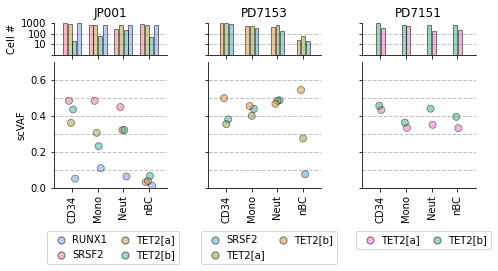

In [15]:
#plot the data
fig, (ax1,ax2) = plt.subplots(2, 3, figsize = (7,4), gridspec_kw = dict(height_ratios = [1,4]), sharex = True) 

ax = ax1
for count, pt in enumerate(pts):
    data = bar_data.loc[bar_data['Pt'].isin([pt])]
    
    for i, row in data.iterrows():
        x = row['x_value']
        y = row['cell_count']
        color = allVAFcols[row['Amplicon']]
        
        ax[count].bar([x], [y], width = 0.15, color = color, alpha = 0.5,  edgecolor = 'black')
    
    ax[count].set_xticks(np.arange(len(cell_order)))
    ax[count].set_xticklabels(cell_order)
    ax[count].set_yscale('log')
    ax[count].set_ylim(1, 1000)
    ax[count].set_yticks([1, 10, 100, 1000])
    ax1labels = ['', 10, 100, 1000]
    ax[count].set_yticklabels(ax1labels)
    ax[count].spines['top'].set_visible(False)
    ax[count].spines['right'].set_visible(False)
    if count != 0:
        ax[count].set_yticklabels([])
    else:
        ax[count].set_ylabel('Cell #')
    
    ax[count].axhline(10, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(100, ls = '--', c = 'silver', lw = 1, zorder = 0)

ax = ax2

for count, pt in enumerate(pts):
    
    data = plate1_all.loc[plate1_all['Pt'].isin([pt])]
    
    sns.scatterplot(x = 'x_value', y = 'VAF', data = data, s = 50, hue = 'Amplicon', palette = allVAFcols,  edgecolor = 'black', alpha = 0.5, ax = ax[count])
    handles, labels = ax[count].get_legend_handles_labels() 
    
    #rename labels for amplicons
    lbl = [] 
    for lb in labels:
        if lb not in all_amps:
            lbl.append(lb)
        else:
            lbl.append(relabel[lb])
                
    
    if pt == 'JP001':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [-0.1,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 2, markerscale = 1.2, handles=handles[1:5], labels=lbl[1:5])
    elif pt == 'PD7153':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [-0.1,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 2, markerscale = 1.2, handles=handles[1:4], labels=lbl[1:4])
    elif pt == 'PD7151':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [-0.1,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 2, markerscale = 1.2, handles=handles[1:3], labels=lbl[1:3])
    
    ax[count].set_ylim(0,0.7)
    ax[count].axhline(0.1, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.2, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.3, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.4, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.5, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.6, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].set_ylabel('')
    ax[count].set_xlabel('')
    ax[count].tick_params(axis='x', labelrotation = 90)
    ax1[count].set_title(f'{pt}')
    ax[count].margins(x=0.1)
    
    if count != 0:
        ax[count].set_yticklabels([])
    else:
        ax[count].set_ylabel('scVAF')
    
    #Manually adjust ticks and labels since now plotting at arbitrary x values
    ax[count].set_xticks(np.arange(len(cell_order)))
    ax[count].set_xticklabels(cell_order)
    
    ax[count].spines['top'].set_visible(False)
    ax[count].spines['right'].set_visible(False)
    
    for lh in lgd.legendHandles: 
        lh.set_alpha(0.5)
        lh.set_edgecolor('black')
        
plt.rcParams['svg.fonttype'] = 'none'    
fig.tight_layout(h_pad = 0, w_pad = 2)  
fig.savefig('../Results/sc_VAFs_cell_no.svg',bbox_inches='tight', dpi = 600)